# import Dependencies

In [5]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import copy 

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.decomposition import PCA 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 

import qiskit as qk 
from qiskit import QuantumCircuit, Aer, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.visualization import circuit_drawer, array_to_latex 
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.algorithms import VQC
from qiskit.circuit.library import RealAmplitudes
from qiskit.algorithms.optimizers import COBYLA

# Load and Preprocess data

In [6]:
data, labels = load_breast_cancer()["data"], load_breast_cancer()["target"]
print(f"data shape is {data.shape}\n labels shape is {labels.shape}")

data shape is (569, 30)
 labels shape is (569,)


In [7]:
np.unique(labels)

array([0, 1])

In [8]:
scaler = StandardScaler()
scaler.fit(data)
X = scaler.transform(data)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42)

In [10]:
print(y_test)

[1 0 0 1 1 0 0 0 1 1 1 0 1 0 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0
 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 0 1 1 0 0 1 0
 1 1 1 0 1 1 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 1 0 0 1 0 0 1 1 1 0 1 1 0
 1 1 0 1 0 1 1 1 0 1 1 1 0 1 0 0 1 1 0 0 0 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0 0
 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1]


# Reduece dimension of data using pca and lda

In [11]:
# reduce dimension of data using LDA and PCA 
pca = PCA(n_components=10)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

# Convert dataset to quantum bits(qubits)

In [12]:
N_pca = 10

def feature_map(X):
    q = QuantumRegister(N_pca)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(q,c)
    for i, x in enumerate(X):
        qc.rx(x,i)
    return qc, c

In [13]:
def variational_circuit (qc,theta):
    for i in range(N_pca-1):
        qc.cnot(i, i+1)
    qc.cnot(N_pca-1,0)    
    qc.barrier()
    for i in range(N_pca):
        qc.ry(theta[i], i)
    return qc

{'0': 49112, '1': 50888}
0.50888


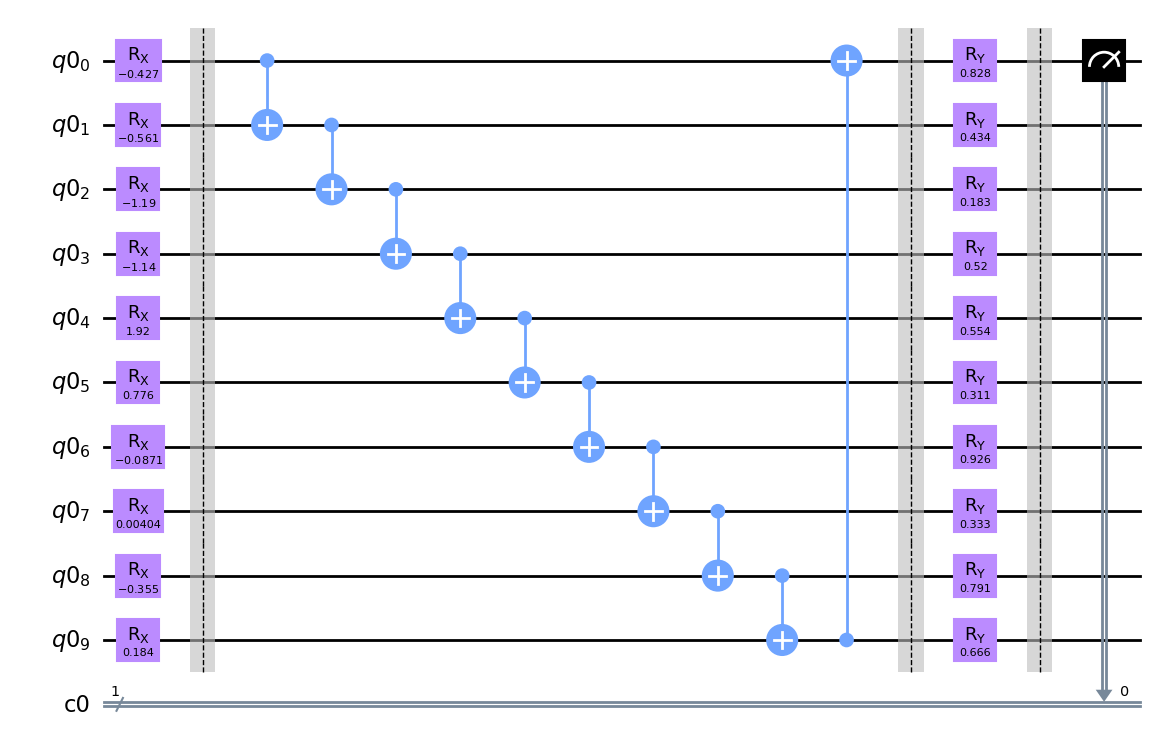

In [14]:
qc, c = feature_map(x_train_pca[6])
qc.barrier()
qc=variational_circuit(qc, np.random.rand(N_pca))
qc.barrier()
qc.measure(0,c)

shots = int(1e5)
backend=Aer.get_backend('qasm_simulator')
job=qk.execute(qc, backend, shots=shots)
result=job.result()
counts=result.get_counts(qc)

print(counts)
print(counts['1']/shots)

qc.draw('mpl')


In [15]:
print(y_train[6])

1


In [16]:
def quantum_nn(X, theta, simulator =True):
    qc, c = feature_map(X)
    qc = variational_circuit(qc, theta)
    qc.measure(0,c)
    shots = int(1E5)
    backend = Aer.get_backend('qasm_simulator')
    job = qk.execute(qc,backend, shots=shots)
    counts = job.result().get_counts(qc)
    return counts['1']/shots


In [17]:
def loss(prediction, target):
    return(prediction-target)**2

In [18]:
def gradient(X,Y, theta):
    delta=0.01
    grad=[]
    for i in range(len(theta)):
        dtheta = copy.copy(theta)
        dtheta[i] += delta
        pred1 = quantum_nn(X, dtheta)
        pred2 = quantum_nn(X, theta)
        grad.append((loss(pred1, Y) - loss(pred2, Y)) / delta)
        return np.array(grad)


In [19]:
def accuracy (X,Y, theta):
    counter=0
    for X_i, Y_i in zip(X, Y):
        prediction=quantum_nn(X_i, theta)
        if prediction<0.5 and Y_i==0:
            counter+=1
        elif prediction>=0.5 and Y_i==1:
            counter+=1
    return counter/len(Y)


In [16]:
eta=0.03
loss_list=[]
theta= np.ones(N_pca)

print('Epoch\t Loss\t Training Accuracy')

for i in range(18):
    loss_tmp=[]
    
    for X_i, Y_i in zip(x_train_pca, y_train):
        prediction = quantum_nn(X_i, theta)
        loss_tmp.append(loss(prediction,Y_i))
        theta=theta-eta*gradient(X_i, Y_i, theta)
        
    loss_list.append(np.mean(loss_tmp))
    acc = accuracy(x_train_pca, y_train, theta)
    print(f'{i} \t {loss_list[-1]:.3f} \t {acc:.3f}')

Epoch	 Loss	 Training Accuracy
0 	 0.253 	 0.475
1 	 0.252 	 0.480
2 	 0.251 	 0.523
3 	 0.250 	 0.555
4 	 0.249 	 0.520
5 	 0.249 	 0.528
6 	 0.250 	 0.465


In [ ]:
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()

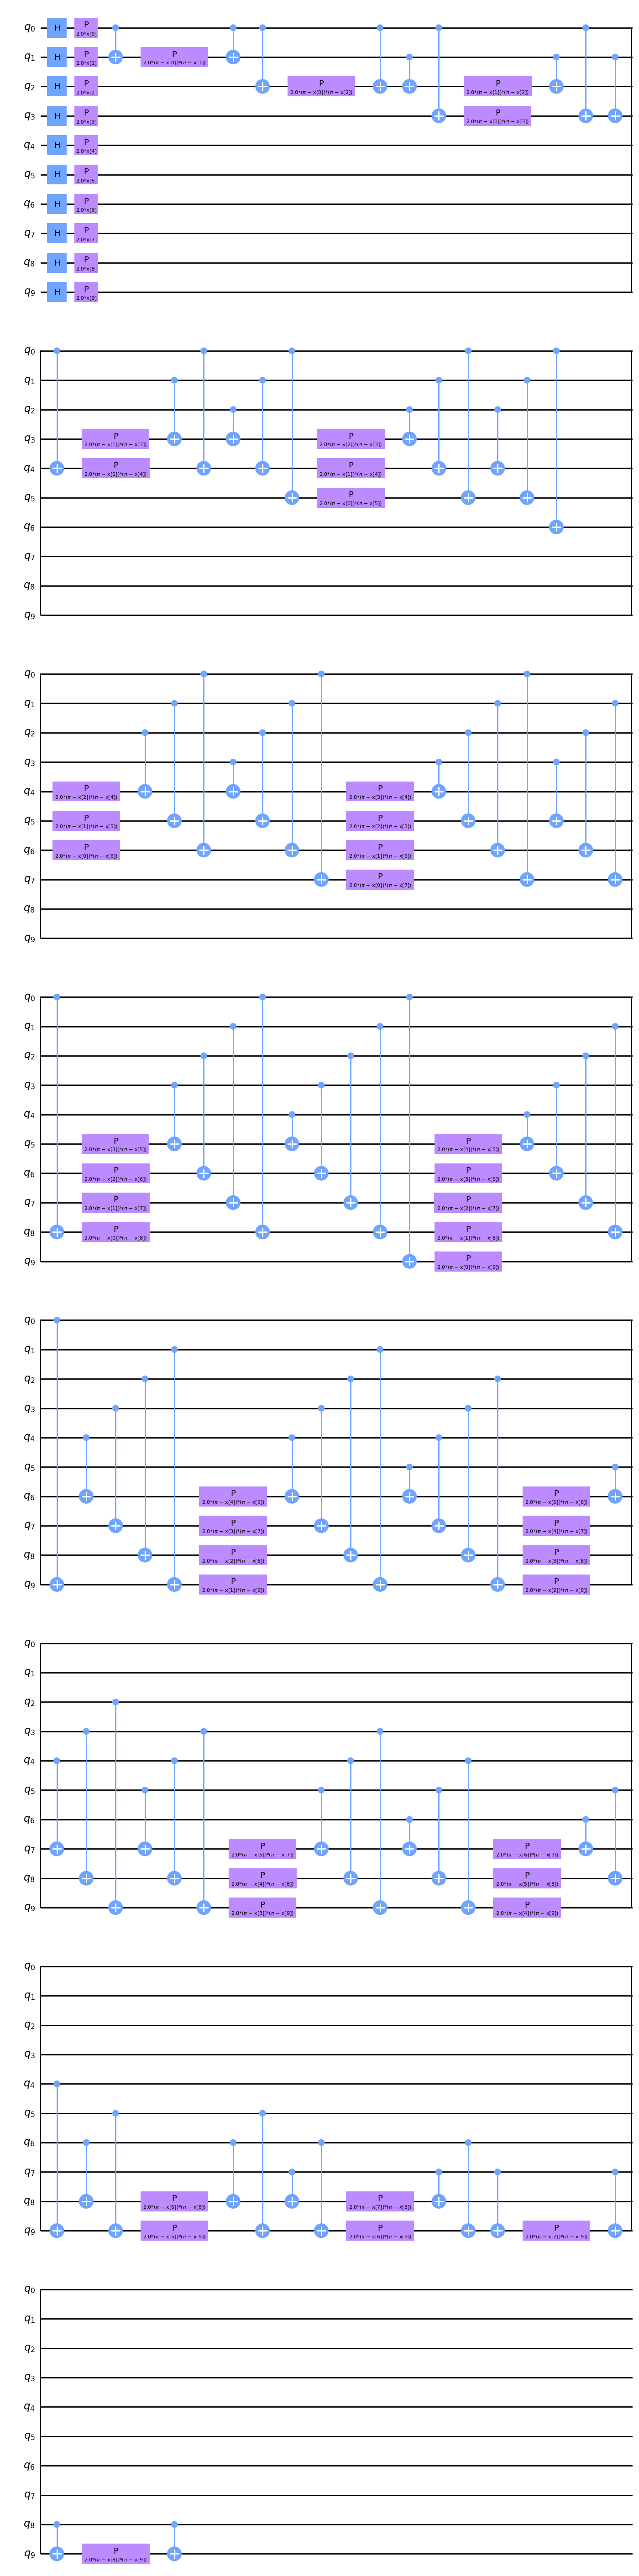

In [23]:
num_features = x_train_pca.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", fold=20)

In [24]:
from qiskit.primitives import Sampler

ansatz = RealAmplitudes(num_qubits=N_pca, reps=3)
ansatz.decompose().draw(output="mpl", fold=20)
optimizer = COBYLA(maxiter=100)
sampler = Sampler()

In [25]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

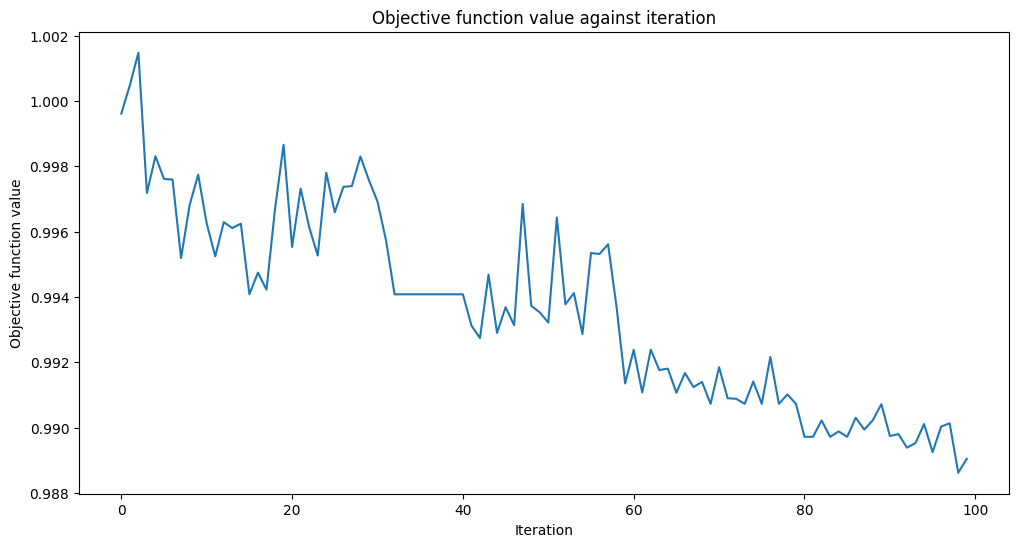

Training time: 5537 seconds


In [26]:
import time 

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(x_train_pca, y_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [27]:
train_score_q4 = vqc.score(x_train_pca, y_train)
test_score_q4 = vqc.score(x_test_pca, y_test)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.63
Quantum VQC on the test dataset:     0.51
